In [1]:
# -*- coding: utf-8 -*-

# 代码12-1 评论去重的代码

import pandas as pd
import re
import jieba.posseg as psg
import numpy as np


# 去重，去除完全重复的数据
reviews = pd.read_csv("../tmp/reviews.csv")
reviews = reviews[['content', 'content_type']].drop_duplicates()
content = reviews['content']

In [2]:
# 代码12-2 数据清洗

# 去除去除英文、数字等
# 由于评论主要为京东美的电热水器的评论，因此去除这些词语
strinfo = re.compile('[0-9a-zA-Z]|京东|美的|电热水器|热水器|')
content = content.apply(lambda x: strinfo.sub('', x))

In [3]:
# 代码12-3 分词、词性标注、去除停用词代码

# 分词
worker = lambda s: [(x.word, x.flag) for x in psg.cut(s)] # 自定义简单分词函数
seg_word = content.apply(worker)

# 将词语转为数据框形式，一列是词，一列是词语所在的句子ID，最后一列是词语在该句子的位置
n_word = seg_word.apply(lambda x: len(x))  # 每一评论中词的个数

n_content = [[x+1]*y for x,y in zip(list(seg_word.index), list(n_word))]
index_content = sum(n_content, [])  # 将嵌套的列表展开，作为词所在评论的id

seg_word = sum(seg_word, [])
word = [x[0] for x in seg_word]  # 词

nature = [x[1] for x in seg_word]  # 词性

content_type = [[x]*y for x,y in zip(list(reviews['content_type']), list(n_word))]
content_type = sum(content_type, [])  # 评论类型

result = pd.DataFrame({"index_content":index_content,
                       "word":word,
                       "nature":nature,
                       "content_type":content_type})

# 删除标点符号
result = result[result['nature'] != 'x']  # x表示标点符号

# 删除停用词
stop_path = open("../data/stoplist.txt", 'r',encoding='UTF-8')
stop = stop_path.readlines()
stop = [x.replace('\n', '') for x in stop]
word = list(set(word) - set(stop))
result = result[result['word'].isin(word)]

# 构造各词在对应评论的位置列
n_word = list(result.groupby(by = ['index_content'])['index_content'].count())
index_word = [list(np.arange(0, y)) for y in n_word]
index_word = sum(index_word, [])  # 表示词语在改评论的位置

# 合并评论id，评论中词的id，词，词性，评论类型
result['index_word'] = index_word

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\23571\AppData\Local\Temp\jieba.cache
Loading model cost 0.600 seconds.
Prefix dict has been built successfully.


In [4]:
# 代码12-4 提取含有名词的评论

# 提取含有名词类的评论
ind = result[['n' in x for x in result['nature']]]['index_content'].unique()
result = result[[x in ind for x in result['index_content']]]

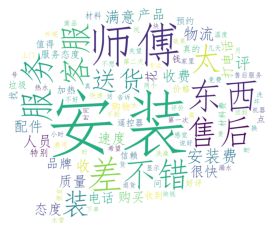

In [5]:
# 代码12-5 绘制词云

import matplotlib.pyplot as plt
from wordcloud import WordCloud

frequencies = result.groupby(by = ['word'])['word'].count()
frequencies = frequencies.sort_values(ascending = False)
backgroud_Image=plt.imread('../data/pl.jpg')
# wordcloud = WordCloud(font_path="STZHONGS.ttf",
#                       max_words=100,
#                       background_color='white',
#                       mask=backgroud_Image)
wordcloud = WordCloud(font_path="simfang.ttf",
                      max_words=100,
                      background_color='white',
                      mask=backgroud_Image)
my_wordcloud = wordcloud.fit_words(frequencies)
plt.imshow(my_wordcloud)
plt.axis('off')
plt.show()

# 将结果写出
result.to_csv("../tmp/word.csv", index = False, encoding = 'utf-8')

In [6]:
# -*- coding: utf-8 -*-

# 代码12-6 匹配情感词

import pandas as pd
import numpy as np
word = pd.read_csv("../tmp/word.csv")

# 读入正面、负面情感评价词
pos_comment = pd.read_csv("../data/正面评价词语（中文）.txt", header=None,sep="tipdm",
                          encoding = 'utf-8', engine='python')
neg_comment = pd.read_csv("../data/负面评价词语（中文）.txt", header=None,sep="tipdm",
                          encoding = 'utf-8', engine='python')
pos_emotion = pd.read_csv("../data/正面情感词语（中文）.txt", header=None,sep="tipdm",
                          encoding = 'utf-8', engine='python')
neg_emotion = pd.read_csv("../data/负面情感词语（中文）.txt", header=None,sep="tipdm",
                          encoding = 'utf-8', engine='python')

# 合并情感词与评价词
positive = set(pos_comment.iloc[:,0])|set(pos_emotion.iloc[:,0])
negative = set(neg_comment.iloc[:,0])|set(neg_emotion.iloc[:,0])
intersection = positive&negative  # 正负面情感词表中相同的词语
positive = list(positive - intersection)
negative = list(negative - intersection)
positive = pd.DataFrame({"word":positive,
                         "weight":[1]*len(positive)})
negative = pd.DataFrame({"word":negative,
                         "weight":[-1]*len(negative)})

posneg = positive.append(negative)

#  将分词结果与正负面情感词表合并，定位情感词
data_posneg = posneg.merge(word, left_on = 'word', right_on = 'word',
                           how = 'right')
data_posneg = data_posneg.sort_values(by = ['index_content','index_word'])

C:\Users\23571\AppData\Local\Temp\ipykernel_32796\2727097386.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  posneg = positive.append(negative)


In [7]:
# 代码12-7 修正情感倾向

# 根据情感词前时候有否定词或双层否定词对情感值进行修正
# 载入否定词表
notdict = pd.read_csv("../data/not.csv")

# 处理否定修饰词
data_posneg['amend_weight'] = data_posneg['weight']  # 构造新列，作为经过否定词修正后的情感值
data_posneg['id'] = np.arange(0, len(data_posneg))
only_inclination = data_posneg.dropna()  # 只保留有情感值的词语
only_inclination.index = np.arange(0, len(only_inclination))
index = only_inclination['id']

for i in np.arange(0, len(only_inclination)):
    review = data_posneg[data_posneg['index_content'] ==
                         only_inclination['index_content'][i]]  # 提取第i个情感词所在的评论
    review.index = np.arange(0, len(review))
    affective = only_inclination['index_word'][i]  # 第i个情感值在该文档的位置
    if affective == 1:
        ne = sum([i in notdict['term'] for i in review['word'][affective - 1]])
        if ne == 1:
            data_posneg['amend_weight'][index[i]] = -\
            data_posneg['weight'][index[i]]
    elif affective > 1:
        ne = sum([i in notdict['term'] for i in review['word'][[affective - 1,
                  affective - 2]]])
        if ne == 1:
            data_posneg['amend_weight'][index[i]] = -\
            data_posneg['weight'][index[i]]

# 更新只保留情感值的数据
only_inclination = only_inclination.dropna()

# 计算每条评论的情感值
emotional_value = only_inclination.groupby(['index_content'],
                                           as_index=False)['amend_weight'].sum()

# 去除情感值为0的评论
emotional_value = emotional_value[emotional_value['amend_weight'] != 0]

In [8]:
# 代码12-8 查看情感分析效果

# 给情感值大于0的赋予评论类型（content_type）为pos,小于0的为neg
emotional_value['a_type'] = ''
emotional_value['a_type'][emotional_value['amend_weight'] > 0] = 'pos'
emotional_value['a_type'][emotional_value['amend_weight'] < 0] = 'neg'

# 查看情感分析结果
result = emotional_value.merge(word,
                               left_on = 'index_content',
                               right_on = 'index_content',
                               how = 'left')

result = result[['index_content','content_type', 'a_type']].drop_duplicates()
confusion_matrix = pd.crosstab(result['content_type'], result['a_type'],
                               margins=True)  # 制作交叉表
(confusion_matrix.iat[0,0] + confusion_matrix.iat[1,1])/confusion_matrix.iat[2,2]

# 提取正负面评论信息
ind_pos = list(emotional_value[emotional_value['a_type'] == 'pos']['index_content'])
ind_neg = list(emotional_value[emotional_value['a_type'] == 'neg']['index_content'])
posdata = word[[i in ind_pos for i in word['index_content']]]
negdata = word[[i in ind_neg for i in word['index_content']]]

C:\Users\23571\AppData\Local\Temp\ipykernel_32796\2240264934.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emotional_value['a_type'][emotional_value['amend_weight'] > 0] = 'pos'
C:\Users\23571\AppData\Local\Temp\ipykernel_32796\2240264934.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emotional_value['a_type'][emotional_value['amend_weight'] < 0] = 'neg'


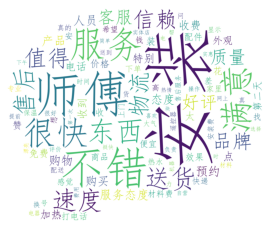

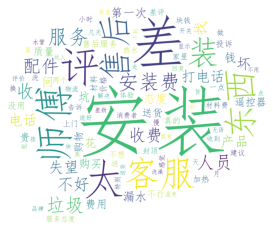

In [9]:
# 绘制词云
import matplotlib.pyplot as plt
from wordcloud import WordCloud
# 正面情感词词云
freq_pos = posdata.groupby(by = ['word'])['word'].count()
freq_pos = freq_pos.sort_values(ascending = False)
backgroud_Image=plt.imread('../data/pl.jpg')
wordcloud = WordCloud(font_path="simfang.ttf",
                      max_words=100,
                      background_color='white',
                      mask=backgroud_Image)
pos_wordcloud = wordcloud.fit_words(freq_pos)
plt.imshow(pos_wordcloud)
plt.axis('off')
plt.show()
# 负面情感词词云
freq_neg = negdata.groupby(by = ['word'])['word'].count()
freq_neg = freq_neg.sort_values(ascending = False)
neg_wordcloud = wordcloud.fit_words(freq_neg)
plt.imshow(neg_wordcloud)
plt.axis('off')
plt.show()

# 将结果写出,每条评论作为一行
posdata.to_csv("../tmp/posdata.csv", index = False, encoding = 'utf-8')
negdata.to_csv("../tmp/negdata.csv", index = False, encoding = 'utf-8')

In [10]:
# -*- coding: utf-8 -*-

# 代码12-9 建立词典及语料库

import pandas as pd
import numpy as np
import re
import itertools
import matplotlib.pyplot as plt

# 载入情感分析后的数据
posdata = pd.read_csv("../data/posdata.csv", encoding = 'utf-8')
negdata = pd.read_csv("../data/negdata.csv", encoding = 'utf-8')

from gensim import corpora, models
# 建立词典
pos_dict = corpora.Dictionary([[i] for i in posdata['word']])  # 正面
neg_dict = corpora.Dictionary([[i] for i in negdata['word']])  # 负面

# 建立语料库
pos_corpus = [pos_dict.doc2bow(j) for j in [[i] for i in posdata['word']]]  # 正面
neg_corpus = [neg_dict.doc2bow(j) for j in [[i] for i in negdata['word']]]   # 负面

Text(0.5, 0, '负面评论LDA主题数寻优')

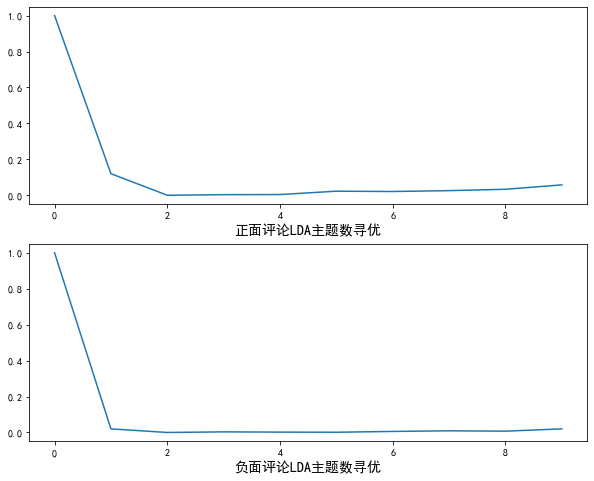

In [11]:

# 代码12-10 主题数寻优

# 构造主题数寻优函数
def cos(vector1, vector2):  # 余弦相似度函数
    dot_product = 0.0;
    normA = 0.0;
    normB = 0.0;
    for a,b in zip(vector1, vector2):
        dot_product += a*b
        normA += a**2
        normB += b**2
    if normA == 0.0 or normB==0.0:
        return(None)
    else:
        return(dot_product / ((normA*normB)**0.5))

# 主题数寻优
def lda_k(x_corpus, x_dict):

    # 初始化平均余弦相似度
    mean_similarity = []
    mean_similarity.append(1)

    # 循环生成主题并计算主题间相似度
    for i in np.arange(2,11):
        lda = models.LdaModel(x_corpus, num_topics = i, id2word = x_dict)  # LDA模型训练
        for j in np.arange(i):
            term = lda.show_topics(num_words = 50)

        # 提取各主题词
        top_word = []
        for k in np.arange(i):
            top_word.append([''.join(re.findall('"(.*)"',i)) \
                             for i in term[k][1].split('+')])  # 列出所有词

        # 构造词频向量
        word = sum(top_word,[])  # 列出所有的词
        unique_word = set(word)  # 去除重复的词

        # 构造主题词列表，行表示主题号，列表示各主题词
        mat = []
        for j in np.arange(i):
            top_w = top_word[j]
            mat.append(tuple([top_w.count(k) for k in unique_word]))

        p = list(itertools.permutations(list(np.arange(i)),2))
        l = len(p)
        top_similarity = [0]
        for w in np.arange(l):
            vector1 = mat[p[w][0]]
            vector2 = mat[p[w][1]]
            top_similarity.append(cos(vector1, vector2))

        # 计算平均余弦相似度
        mean_similarity.append(sum(top_similarity)/l)
    return(mean_similarity)

# 计算主题平均余弦相似度
pos_k = lda_k(pos_corpus, pos_dict)
neg_k = lda_k(neg_corpus, neg_dict)

# 绘制主题平均余弦相似度图形
from matplotlib.font_manager import FontProperties
font = FontProperties(size=14)
#解决中文显示问题
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(211)
ax1.plot(pos_k)
ax1.set_xlabel('正面评论LDA主题数寻优', fontproperties=font)

ax2 = fig.add_subplot(212)
ax2.plot(neg_k)
ax2.set_xlabel('负面评论LDA主题数寻优', fontproperties=font)

In [14]:
# 代码12-11 LDA主题分析

# LDA主题分析
pos_lda = models.LdaModel(pos_corpus, num_topics = 3, id2word = pos_dict)
neg_lda = models.LdaModel(neg_corpus, num_topics = 3, id2word = neg_dict)
pos_lda.print_topics(num_words = 10)
neg_lda.print_topics(num_words = 10)

[(0,
  '0.034*"垃圾" + 0.033*"师傅" + 0.032*"售后" + 0.021*"客服" + 0.019*"小时" + 0.019*"不好" + 0.017*"烧水" + 0.016*"太慢" + 0.014*"人员" + 0.012*"材料"'),
 (1,
  '0.127*"安装" + 0.027*"差" + 0.023*"安装费" + 0.018*"装" + 0.017*"打电话" + 0.016*"贵" + 0.015*"慢" + 0.014*"漏水" + 0.012*"真的" + 0.010*"问"'),
 (2,
  '0.031*"太" + 0.022*"东西" + 0.018*"收" + 0.018*"收费" + 0.017*"加热" + 0.013*"坑人" + 0.012*"服务" + 0.011*"产品" + 0.011*"上门" + 0.010*"评"')]